In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline

In [10]:
df = pd.read_table('/data/NCR_SBRB/simplex/xhmm/DATA_gene_disrupt_q10.denovo.cnv')
df.rename(index=str, columns={'#CLASS': 'CLASS'}, inplace=True)
df.head()

,CLASS,CHILD,LOCUS,CNV,NUM_TARG,PAR_WITH,PAR_WITHOUT,PAR_MISS,CHILD_WITH,CHILD_WITHOUT,CHILD_MISS
0,DENOVO,CLIA_400138,chr1:14510..70018,<DUP>,16,10,27,5,9,39,0
1,MATERNAL_TRANSMITTED,CLIA_400152,chr1:19051..70018,<DEL>,7,5,33,4,9,38,1
2,MATERNAL_NON_TRANSMITTED,CLIA_400153,chr1:19051..70018,<DEL>,7,5,33,4,10,37,1
3,PATERNAL_NON_TRANSMITTED,CLIA_400162,chr1:69036..120881,<DUP>,6,6,34,2,7,41,0
4,PATERNAL_NON_TRANSMITTED,CLIA_400163,chr1:69036..120881,<DUP>,6,6,34,2,7,41,0


OK, so this is working. Let's then make the matrices we'll need to replicate the plots from before:

In [14]:
quality = range(10, 100, 10)
dfs = []

for qual in quality:
    df = pd.read_table('/data/NCR_SBRB/simplex/xhmm/DATA_gene_disrupt_q%d.denovo.cnv' % qual)
    df.rename(index=str, columns={'#CLASS': 'CLASS'}, inplace=True)
    dfs.append(df)

In [19]:
children = np.unique(df.CHILD)
nchildren = len(children)
ncnvs = np.zeros([nchildren, len(quality)])
ndnms = np.zeros([nchildren, len(quality)])

for c, child in enumerate(children):
    for q in range(len(quality)):
        ncnvs[c, q] = np.sum(dfs[q].CHILD == child)
        idx = np.logical_and(dfs[q].CHILD == child, dfs[q].CLASS == 'DENOVO')
        ndnms[c, q] = np.sum(idx)

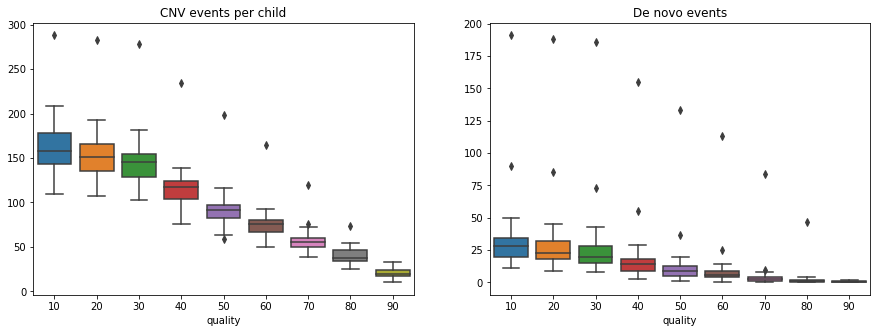

In [25]:
fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.boxplot(data=[ncnvs[:, q] for q in range(len(quality))], orient='v')
plt.xlabel('quality')
plt.title('CNV events per child')
locs, labels = plt.xticks(range(len(quality)), quality)

plt.subplot(1, 2, 2)
sns.boxplot(data=[ndnms[:, q] for q in range(len(quality))], orient='v')
plt.xlabel('quality')
plt.title('De novo events')
locs, labels = plt.xticks(range(len(quality)), quality)

We already knew we'd have some outliers, based on the overall XHMM plots, but we certainly need to figure out who they are. Also, it's great that our numbers ar elooking more like the XHMM original paper numbers! In fact, they had some outliers as well. If we were to specify some sort of frequency threshold to the CNVs, or even tweak the HMM parameters a bit, we can shift those numbers up and down if needed.

Now that we have the total number of CNV events for each child in the trios, let's see if ADHD trios have more disruptive denovo or total CNVs:

In [26]:
# figure out who is who in each trio

import glob
data_dir = '/data/NCR_SBRB/simplex/'
trios = {}
affected = []
controls = []
peds = glob.glob(data_dir + '*trio*ped')
for ped in peds:
    trio_name = ped.split('/')[-1].split('.')[0]
    fid = open(ped, 'r')
    fam = {}
    for line in fid:
        famid, sid, fa, mo, sex, aff = line.rstrip().split('\t')
        if fa != '0':
            fam['child'] = sid
            if aff == '1':
                affected.append(trio_name)
            else:
                controls.append(trio_name)
        elif sex == '1':
            fam['father'] = sid
        else:
            fam['mother'] = sid
    trios[trio_name] = fam
    fid.close()
    
fid = open('/data/NCR_SBRB/simplex/famids.txt', 'r')
fams = [t.rstrip() for t in fid]
fid.close()

# CCGO_800976 was removed during sample filtering step in XHMM, let's remove the family that has that sample, as it's a father
del trios['10369_trio1']
del trios['10369_trio2']
fams.remove('10369')

In [30]:
from scipy import stats
rel_ps = []
wilcoxon_ps = []
for q, qual in enumerate(quality):
    x, y = [], []
    for fam in fams:
        # this family only has an affected trio
        if fam != '10042':
            keys = [k for k in trios.iterkeys() if k.find(fam)==0]
            keys.sort()
            # now keys has the affected trio first, all others aftewards
            k = np.nonzero(children == trios[keys[0]]['child'])[0][0]
            x.append(ndnms[k, q])
            k = np.nonzero(children == trios[keys[1]]['child'])[0][0]
            y.append(ndnms[k, q])
    stat, pval = stats.wilcoxon(x, y)
    wilcoxon_ps.append(pval)
    stat, pval = stats.ttest_rel(x, y)
    rel_ps.append(pval)
print 'Only one pair per family:'
print 'Nonparametric:', wilcoxon_ps
print 'T-test:', rel_ps

ttest_ps = []
mann_ps = []
for q, qual in enumerate(quality):
    x, y = [], []
    for fam in fams:
        # this family only has an affected trio
        if fam != '10042':
            keys = [k for k in trios.iterkeys() if k.find(fam)==0]
            keys.sort()
            # now keys has the affected trio first, all others aftewards
            k = np.nonzero(children == trios[keys[0]]['child'])[0][0]
            x.append(ndnms[k, q])
            for mykey in keys[1:]:
                k = np.nonzero(children == trios[mykey]['child'])[0][0]
                y.append(ndnms[k, q])
    stat, pval = stats.mannwhitneyu(x, y)
    mann_ps.append(pval)
    stat, pval = stats.ttest_ind(x, y)
    ttest_ps.append(pval)
print 'All pairs:'
print 'Non-parametric:', mann_ps
print 'T-test:', ttest_ps

Only one pair per family:
Nonparametric: [0.53224926354512392, 0.50660682069574703, 0.53212438190009514, 0.72207723178217575, 0.84387756566758187, 0.6555002383818942, 0.64685855760076771, 0.95187117457673287, 0.73888268036352733]
T-test: [0.50844100667987191, 0.49238809762741598, 0.47781889909757969, 0.47425800896313297, 0.47401279051244305, 0.40638657967389291, 0.41520495179179595, 0.39046419555125877, 0.74863357085679916]
All pairs:
Non-parametric: [0.079688540280076825, 0.064411971943592106, 0.09176233433295955, 0.11358578146233372, 0.24714130808926404, 0.16197854205097284, 0.46835405686831316, 0.49067810522014971, 0.48256783506915923]
T-test: [0.24661640862815806, 0.23548551490905389, 0.24818983195110902, 0.25121158037408958, 0.27700981392294954, 0.24190346458986461, 0.27340098466721785, 0.26560870008958759, 0.90777580660855106]


Nothing there for de novo mutations... what about all CNVs?

In [31]:
rel_ps = []
wilcoxon_ps = []
for q, qual in enumerate(quality):
    x, y = [], []
    for fam in fams:
        # this family only has an affected trio
        if fam != '10042':
            keys = [k for k in trios.iterkeys() if k.find(fam)==0]
            keys.sort()
            # now keys has the affected trio first, all others aftewards
            k = np.nonzero(children == trios[keys[0]]['child'])[0][0]
            x.append(ncnvs[k, q])
            k = np.nonzero(children == trios[keys[1]]['child'])[0][0]
            y.append(ncnvs[k, q])
    stat, pval = stats.wilcoxon(x, y)
    wilcoxon_ps.append(pval)
    stat, pval = stats.ttest_rel(x, y)
    rel_ps.append(pval)
print 'Only one pair per family:'
print 'Nonparametric:', wilcoxon_ps
print 'T-test:', rel_ps

ttest_ps = []
mann_ps = []
for q, qual in enumerate(quality):
    x, y = [], []
    for fam in fams:
        # this family only has an affected trio
        if fam != '10042':
            keys = [k for k in trios.iterkeys() if k.find(fam)==0]
            keys.sort()
            # now keys has the affected trio first, all others aftewards
            k = np.nonzero(children == trios[keys[0]]['child'])[0][0]
            x.append(ncnvs[k, q])
            for mykey in keys[1:]:
                k = np.nonzero(children == trios[mykey]['child'])[0][0]
                y.append(ncnvs[k, q])
    stat, pval = stats.mannwhitneyu(x, y)
    mann_ps.append(pval)
    stat, pval = stats.ttest_ind(x, y)
    ttest_ps.append(pval)
print 'All pairs:'
print 'Non-parametric:', mann_ps
print 'T-test:', ttest_ps

Only one pair per family:
Nonparametric: [0.53224926354512392, 0.50660682069574703, 0.53212438190009514, 0.72207723178217575, 0.84387756566758187, 0.6555002383818942, 0.64685855760076771, 0.95187117457673287, 0.73888268036352733]
T-test: [0.50844100667987191, 0.49238809762741598, 0.47781889909757969, 0.47425800896313297, 0.47401279051244305, 0.40638657967389291, 0.41520495179179595, 0.39046419555125877, 0.74863357085679916]
All pairs:
Non-parametric: [0.28465215748233974, 0.27336643835631647, 0.31170851964651675, 0.21081391714567105, 0.21399525652509138, 0.21973689510810962, 0.48662971054212012, 0.36452463990088574, 0.48660108532104546]
T-test: [0.35157999218144576, 0.30757470876788101, 0.30975468810084478, 0.28590427669184554, 0.27621705550953768, 0.23150452255279355, 0.33782649711295221, 0.43446703943362408, 0.9771694405754523]


Not really... oh well. Let's look at more samples, and work on cleaning up the XHMM results a bit further, after adding new samples.

# TODO

* specify some sort of frequency threshold for CNVs?